In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ann-car-sales-price-prediction/car_purchasing.csv


In [2]:

# Encoded
encodings = ['latin1', 'iso-8859-1', 'cp1252', 'utf-16'] 

for encoding in encodings:
    try:
        df = pd.read_csv('/kaggle/input/ann-car-sales-price-prediction/car_purchasing.csv', encoding=encoding)
        print(f"Succès avec l'encodage: {encoding}")
        break
    except:
        print(f"Échec avec l'encodage: {encoding}")
        continue

Succès avec l'encodage: latin1


In [3]:
import chardet

with open('/kaggle/input/ann-car-sales-price-prediction/car_purchasing.csv', 'rb') as f:
    result = chardet.detect(f.read(10000))  # Analyser un échantillon

df = pd.read_csv('/kaggle/input/ann-car-sales-price-prediction/car_purchasing.csv', 
                encoding=result['encoding'])
df.head(5)

,customer name,customer e-mail,country,gender,age,annual Salary,credit card debt,net worth,car purchase amount
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,Bulgaria,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,Harlan Barnes,eu.dolor@diam.co.uk,Belize,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,Algeria,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,Jade Cunningham,malesuada@dignissim.com,Cook Islands,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,Brazil,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248


Importing Libraries
Loading the necessary tools to manipulate the data and build the model.

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

Feature Selection
Identification of the explanatory variables (features) and the target variable (target) relevant to the model.
Data Preparation
Cleaning and transforming data to make it usable by the model.

In [5]:
#Add more explanatory variables to try to improve the scores
features = ['annual Salary', 'age', 'credit card debt', 'net worth']
X = np.array(df[features])


In [6]:
def prepare_data(df, target_column, forecast_out, test_size):
    df = df.copy()
    df['label'] = df[target_column].shift(-forecast_out)
    
    X = np.array(df[[target_column]])
    X = preprocessing.scale(X)
    X_lately = X[-forecast_out:]
    X = X[:-forecast_out]
    
    df.dropna(inplace=True)
    y = np.array(df['label'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    return X_train, X_test, y_train, y_test, X_lately


Training with Random Forest
Building a model based on multiple decision trees, combining their predictions to improve accuracy.

In [7]:
target_column = 'car purchase amount'
forecast_out = 10
test_size = 0.2

X_train, X_test, y_train, y_test, X_lately = prepare_data(df, target_column, forecast_out, test_size)

learner = RandomForestRegressor()
learner.fit(X_train, y_train)


RandomForestRegressor()

Model Evaluation
Measurement of the model's performance on test data (RMSE) to validate its generalizability.

In [8]:
from sklearn.metrics import mean_squared_error

y_pred = learner.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Train score:", learner.score(X_train, y_train))
print("Test score :", learner.score(X_test, y_test))
print("RMSE       :", rmse)


Train score: 0.8151778226126924
Test score : -0.543180877311753
RMSE       : 12952.519292302395


In [9]:
forecast_set = learner.predict(X_lately)
print(" forecast_set:", forecast_set)

 forecast_set: [43370.5748599 34741.2501847 38617.3857476 45138.085473  43340.3141413
 46451.4491352 42090.4192517 43340.3141413 39260.286422  48807.0840081]


In [10]:
print(df.columns)

Index(['customer name', 'customer e-mail', 'country', 'gender', 'age',
       'annual Salary', 'credit card debt', 'net worth',
       'car purchase amount'],
      dtype='object')


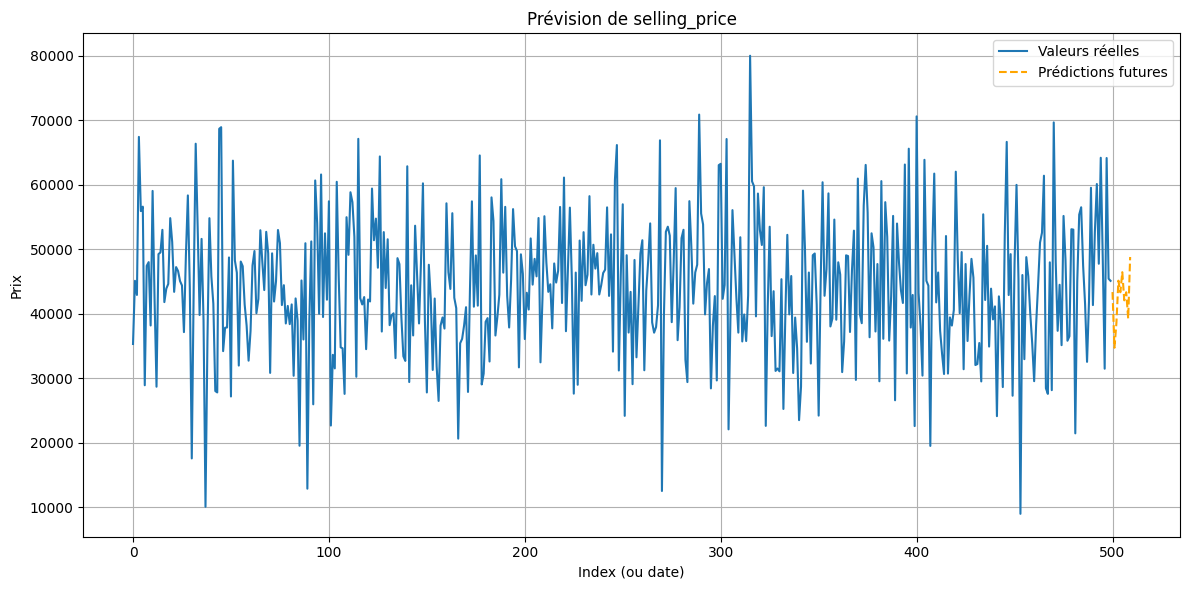

In [11]:
import matplotlib.pyplot as plt
import datetime

# Copying the DataFrame for visualization
df_vis = df[[target_column]].copy()

# Add new column forecast with NaN
df_vis['Forecast'] = np.nan

# The last known numerical index
last_index = df_vis.index[-1]


for i, prediction in enumerate(forecast_set):
    next_index = last_index + i + 1
    df_vis.loc[next_index] = [np.nan, prediction]

# Display
plt.figure(figsize=(12, 6))
plt.plot(df_vis[target_column], label="Valeurs réelles")
plt.plot(df_vis['Forecast'], label="Prédictions futures", linestyle='--', color='orange')
plt.title("Prévision de selling_price")
plt.xlabel("Index (ou date)")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
